<a href="https://colab.research.google.com/github/vishnu1001/aqi-ml-prediction/blob/main/Delhi_AQI_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error #RMSE

from sklearn.preprocessing import MinMaxScaler # for ranged values
from keras.preprocessing.sequence import TimeseriesGenerator

#Importing the necessary components to define our model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM # for precidtion
from keras.layers import Dropout
from keras.optimizers import Adam

from keras.utils import plot_model

#///////////////////////////////////////////////////////////////////////////////

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML,display

warnings.filterwarnings("ignore")

In [ ]:
#Read the daily city-wise data
df = pd.read_csv("city_day.csv", parse_dates=True)

df['Date'] = pd.to_datetime(df['Date'])

#Keeping only the columns needed
#City, Date, AQI
df = df[['City','Date','AQI']]
delhi = df[df['City'] == 'Delhi']

delhi.drop(['City'],axis=1,inplace = True)
delhi.set_index('Date', inplace = True)

delhi

,AQI
Date,
2015-01-01,472.0
2015-01-02,454.0
2015-01-03,143.0
2015-01-04,319.0
2015-01-05,325.0
...,...
2020-06-27,112.0
2020-06-28,196.0
2020-06-29,233.0


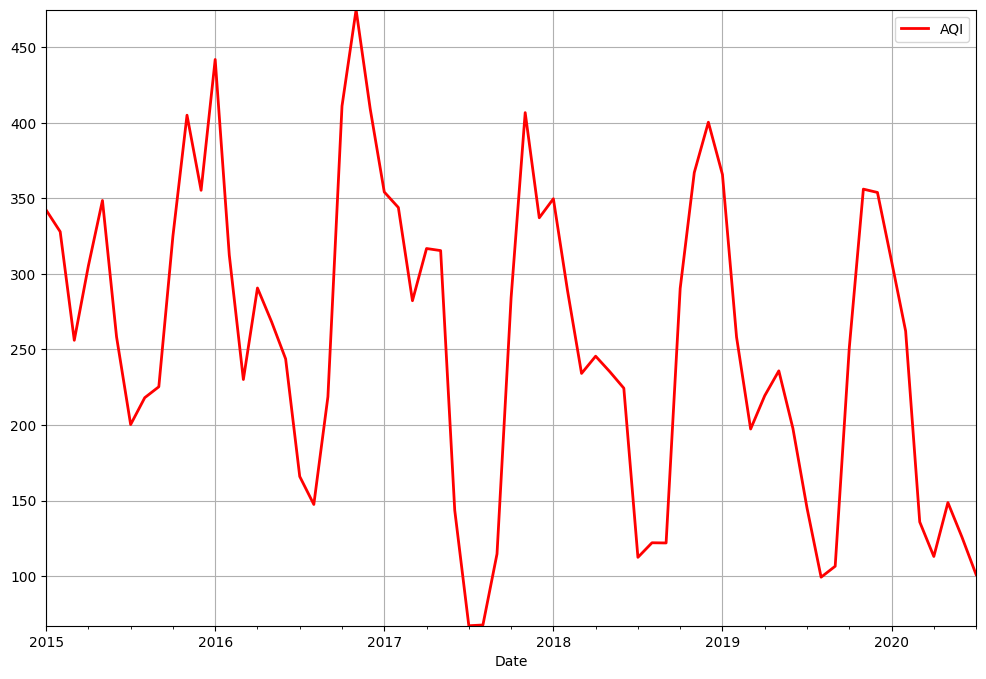

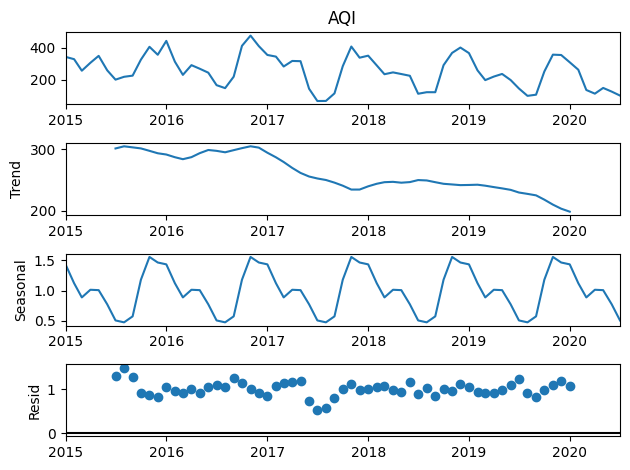

In [ ]:
#Fill NULL DATA
delhi['AQI'].fillna(method = 'bfill',inplace = True)

#Taking monthly average
delhi = delhi.astype('float64')
delhi = delhi.resample(rule='MS').mean()

ax = delhi[['AQI']].plot(figsize=(12,8),grid=True,lw=2,color='Red')
ax.autoscale(enable=True, axis='both', tight=True)
                                                                                           
#Importing seasonal_decompose and mean_squared_error

delhi_AQI=delhi['AQI']
result = seasonal_decompose(delhi_AQI,model='multiplicative')
result.plot();

In [ ]:
#Splitting the training and testing data

train = delhi[:48]
test = delhi[48:61]

type(train)

#print("Shape of train data:" + str(train.array.shape))
#print("Shape of test data:" + str(test.array.shape))

print("Shape of train data: " + str(train.shape))
print("Shape of test data: " + str(test.shape))

#train_arr=np.expand_dims(train, axis=1)
#test_arr=np.expand_dims(test, axis=1)

train_arr = train
test_arr = test

train_arr

Shape of train data: (48, 1)
Shape of test data: (13, 1)


,AQI
Date,
2015-01-01,342.290323
2015-02-01,327.928571
2015-03-01,256.064516
2015-04-01,305.266667
2015-05-01,348.580645
2015-06-01,258.333333
2015-07-01,200.290323
2015-08-01,218.064516
2015-09-01,225.300000


In [ ]:
#Preprocessing the dataset

# Importing MinMaxScaler from sklearn.preprocessing
scaler = MinMaxScaler()

scaler.fit(train_arr)

scaled_train = scaler.transform(train_arr)
scaled_test = scaler.transform(test_arr)

#Defining our time series generator that would be used to parse data into the model

#Importing TimeseriesGenerator from keras.preprocessing.sequence

n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.67487834 0.63964965 0.46337057 0.58406109 0.6903082  0.46893587
 0.32655914 0.37015839 0.38790668 0.63246601 0.82878394 0.70684585]
Predict this y: 
 [[0.91922402]]


Model: "LSTM-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 12, 32)            4352      
                                                                 
 LSTM_2 (LSTM)               (None, 32)                8320      
                                                                 
 DENSE_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


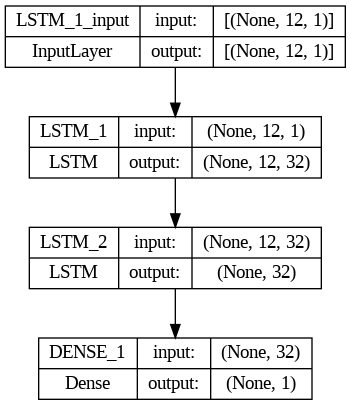

In [ ]:
# #Importing the necessary components to define our model
# #Imported in cell 1

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers import Dropout
# from keras.optimizers import Adam

# defining the stacked LSTM model
model = Sequential(name = 'LSTM-Model')
model.add(LSTM(32, activation='relu', return_sequences = True, input_shape=(n_input, n_features),name = "LSTM_1"))
#model.add(LSTM(100, activation='relu', return_sequences = True,name = "LSTM_2"))
#model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu',name = "LSTM_2"))
#model.add(Dropout(0.2))
#model.add(Dense(8))
model.add(Dense(1,name = "DENSE_1"))
model.compile(optimizer= 'adam',  loss='mse')

model.summary()

#Plotting the layer structure
from keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True,rankdir="TB",dpi=96)

Epoch 1/200
36/36 [==============================] - 3s 9ms/step - loss: 0.2359
Epoch 2/200
36/36 [==============================] - 0s 9ms/step - loss: 0.0833
Epoch 3/200
36/36 [==============================] - 0s 10ms/step - loss: 0.0797
Epoch 4/200
36/36 [==============================] - 0s 9ms/step - loss: 0.0793
Epoch 5/200
36/36 [==============================] - 0s 9ms/step - loss: 0.0761
Epoch 6/200
36/36 [==============================] - 0s 10ms/step - loss: 0.0700
Epoch 7/200
36/36 [==============================] - 0s 11ms/step - loss: 0.0721
Epoch 8/200
36/36 [==============================] - 0s 9ms/step - loss: 0.0741
Epoch 9/200
36/36 [==============================] - 0s 9ms/step - loss: 0.0686
Epoch 10/200
36/36 [==============================] - 0s 13ms/step - loss: 0.0664
Epoch 11/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0664
Epoch 12/200
36/36 [==============================] - 0s 13ms/step - loss: 0.0788
Epoch 13/200
36/36 [===========

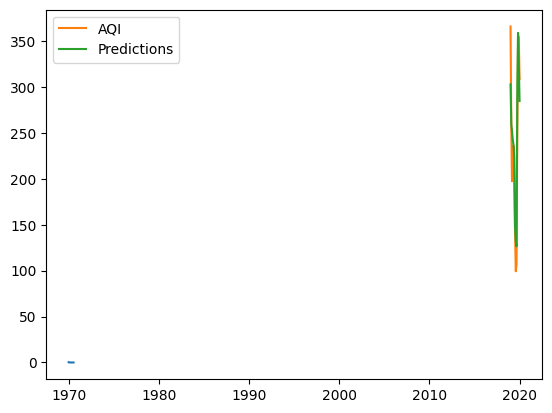

In [ ]:
#Plotting the layer structure
#Importing plot_model form keras.utils

plot_model(model,show_shapes=True,show_layer_names=True,rankdir="TB",dpi=96)

#Fitting our model
model.fit_generator(generator,epochs=200)

#plotting the loss vs #of epoch 
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

#Predicting using our model on the testing dataset
test_predictions = []

first_batch = scaled_train[-n_input:]
current_batch = first_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
      
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

test_predictions = scaler.inverse_transform(test_predictions)

print(test_predictions.shape)
print(test_arr.shape)

test_arr['Predictions'] = test_predictions

#Plotting the true values vs predicted values on testing dataset
plt.plot(test_arr['AQI'],label = 'AQI')
plt.plot(test_arr['Predictions'],label = 'Predictions')

plt.legend()

In [ ]:
#Calculating the root mean squared error on the testing dataset
RMSE_test = np.sqrt(mean_squared_error(test_arr['AQI'],test_arr['Predictions']))
print('RMSE on the testing dataset = ',RMSE_test)
print('India_AQI=',test_arr['AQI'].mean())

#Predicting using our model on the training dataset
train_predictions = []

first_eval_batch = scaled_train[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(train-n_input)):
      
    current_pred = model.predict(current_batch)[0]
    train_predictions.append(current_pred) 
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

train_predictions = scaler.inverse_transform(train_predictions)

print(train_predictions.shape)
print(train_arr.shape)

train_arr['Predictions'] = train_predictions

RMSE on the testing dataset =  31.094290860437123
India_AQI= 238.0504608294931
1/1 [==============================] - 0s 21ms/step
(48, 1)
(48, 1)


RMSE on the training dataset =  54.31217507572275
India_AQI= 275.1711046334552


,AQI
Date,
2015-01-01,342.290323
2015-02-01,327.928571
2015-03-01,256.064516
2015-04-01,305.266667
2015-05-01,348.580645
...,...
2020-03-01,135.838710
2020-04-01,113.000000
2020-05-01,148.645161


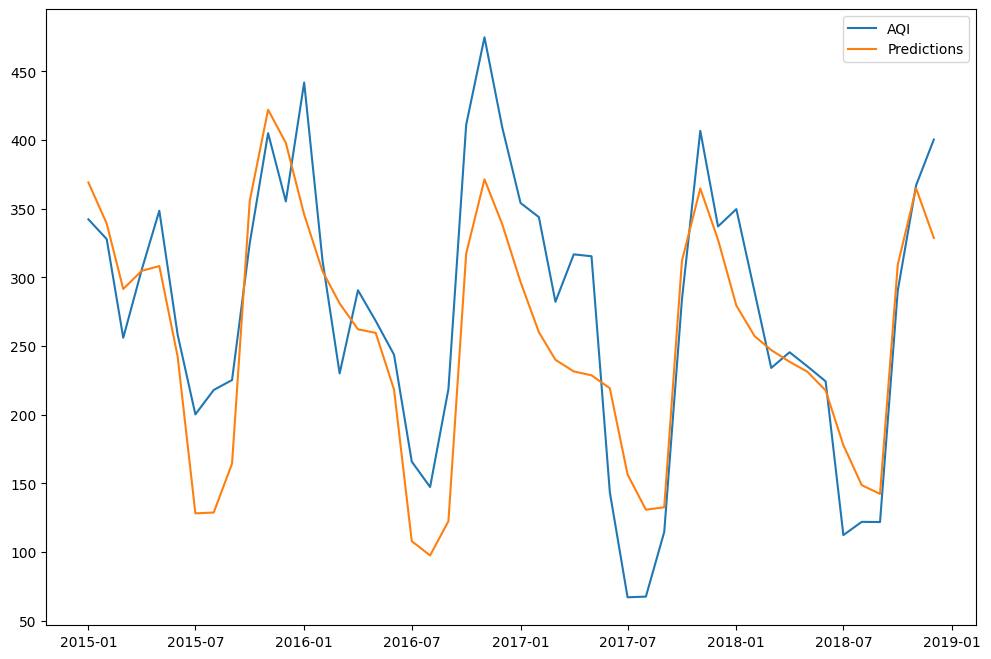

In [ ]:
#Plotting the true values vs predicted values on training dataset
plt.figure(figsize=(12,8))
plt.plot#Plo(train_arr['AQI'],label = 'AQI')
plt.plot(train_arr['Predictions'],label = 'Predictions')
plt.legend()

#Calculating the root mean squared error on the testing dataset
RMSE_train =np.sqrt(mean_squared_error(train_arr['AQI'],train_arr['Predictions']))
print('RMSE on the training dataset = ',RMSE_train)
print('India_AQI=',train_arr['AQI'].mean())

delhi_arr = delhi
scaled_delhi = scaler.transform(delhi_arr)

delhi_arr